In [ ]:
%pip install -q pandas scikit-learn catboost matplotlib seaborn

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier


Datos de la competencia

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip -l udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Carga de datos

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Exploración rápida
print(f"\nColumnas del dataset:")
print(train_df.columns.tolist())
print(f"\nClases en RENDIMIENTO_GLOBAL:")
print(train_df["RENDIMIENTO_GLOBAL"].value_counts())

Train shape: (692500, 21)
Test shape: (296786, 20)

Columnas del dataset:
['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']

Clases en RENDIMIENTO_GLOBAL:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64


Limpieza y preparación

In [ ]:
X = train_df.drop(columns=["RENDIMIENTO_GLOBAL"])
y = train_df["RENDIMIENTO_GLOBAL"]

print(f"Variables predictoras: {X.shape}")
print(f"Variable objetivo: {y.shape}")

# Detectar columnas categóricas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nColumnas categóricas: {len(categorical_features)}")
for col in categorical_features[:5]:  # Mostrar solo las primeras 5
    print(f"  - {col}: {X[col].nunique()} valores únicos")

# Detectar columnas numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nColumnas numéricas: {len(numeric_features)}")

# Limpiar NaN categóricas
for col in categorical_features:
    X[col] = X[col].fillna("Unknown")

# Limpiar NaN numéricas
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

# Obtener índices categóricos para CatBoost
categorical_indices = [X.columns.get_loc(col) for col in categorical_features]
print(f"\nÍndices categóricos para CatBoost: {len(categorical_indices)} columnas")
print("✅ Datos preparados correctamente")

Variables predictoras: (692500, 20)
Variable objetivo: (692500,)

Columnas categóricas: 14
  - ESTU_PRGM_ACADEMICO: 948 valores únicos
  - ESTU_PRGM_DEPARTAMENTO: 31 valores únicos
  - ESTU_VALORMATRICULAUNIVERSIDAD: 8 valores únicos
  - ESTU_HORASSEMANATRABAJA: 5 valores únicos
  - FAMI_ESTRATOVIVIENDA: 7 valores únicos

Columnas numéricas: 6
  - ESTU_PRGM_DEPARTAMENTO: 31 valores únicos
  - ESTU_VALORMATRICULAUNIVERSIDAD: 8 valores únicos
  - ESTU_HORASSEMANATRABAJA: 5 valores únicos
  - FAMI_ESTRATOVIVIENDA: 7 valores únicos

Columnas numéricas: 6

Índices categóricos para CatBoost: 14 columnas
✅ Datos preparados correctamente

Índices categóricos para CatBoost: 14 columnas
✅ Datos preparados correctamente


Entrenamiento del modelo

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Distribución de clases en entrenamiento:")
print(y_train.value_counts())

# Configuración del modelo CatBoost
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_indices,
    random_seed=42,
    verbose=50,  # Mostrar progreso cada 50 iteraciones
    early_stopping_rounds=50,
    use_best_model=True,
    eval_metric='Accuracy',
    task_type='CPU',
    bootstrap_type='Bayesian',
    od_type='Iter'
)

print("\n🚀 Entrenando modelo CatBoost...")
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False)
print("✅ Modelo entrenado correctamente")

X_train shape: (554000, 20)
X_val shape: (138500, 20)
Distribución de clases en entrenamiento:
RENDIMIENTO_GLOBAL
alto          140495
bajo          138390
medio-bajo    137820
medio-alto    137295
Name: count, dtype: int64

🚀 Entrenando modelo CatBoost...
0:	learn: 0.3959513	test: 0.3946931	best: 0.3946931 (0)	total: 4.79s	remaining: 39m 48s
0:	learn: 0.3959513	test: 0.3946931	best: 0.3946931 (0)	total: 4.79s	remaining: 39m 48s
50:	learn: 0.4373809	test: 0.4378339	best: 0.4378484 (49)	total: 3m 14s	remaining: 28m 29s
50:	learn: 0.4373809	test: 0.4378339	best: 0.4378484 (49)	total: 3m 14s	remaining: 28m 29s
100:	learn: 0.4422365	test: 0.4424188	best: 0.4425199 (96)	total: 6m 26s	remaining: 25m 28s
100:	learn: 0.4422365	test: 0.4424188	best: 0.4425199 (96)	total: 6m 26s	remaining: 25m 28s
150:	learn: 0.4449007	test: 0.4440939	best: 0.4440939 (150)	total: 9m 50s	remaining: 22m 44s
150:	learn: 0.4449007	test: 0.4440939	best: 0.4440939 (150)	total: 9m 50s	remaining: 22m 44s
200:	learn: 0.4

Evaluación del modelo

RESULTADOS DE EVALUACIÓN:
Accuracy en validación: 0.4471
              precision    recall  f1-score   support

        alto       0.58      0.63      0.60     35124
        bajo       0.48      0.58      0.52     34597
  medio-alto       0.34      0.30      0.32     34324
  medio-bajo       0.34      0.27      0.30     34455

    accuracy                           0.45    138500
   macro avg       0.43      0.45      0.44    138500
weighted avg       0.43      0.45      0.44    138500

              precision    recall  f1-score   support

        alto       0.58      0.63      0.60     35124
        bajo       0.48      0.58      0.52     34597
  medio-alto       0.34      0.30      0.32     34324
  medio-bajo       0.34      0.27      0.30     34455

    accuracy                           0.45    138500
   macro avg       0.43      0.45      0.44    138500
weighted avg       0.43      0.45      0.44    138500



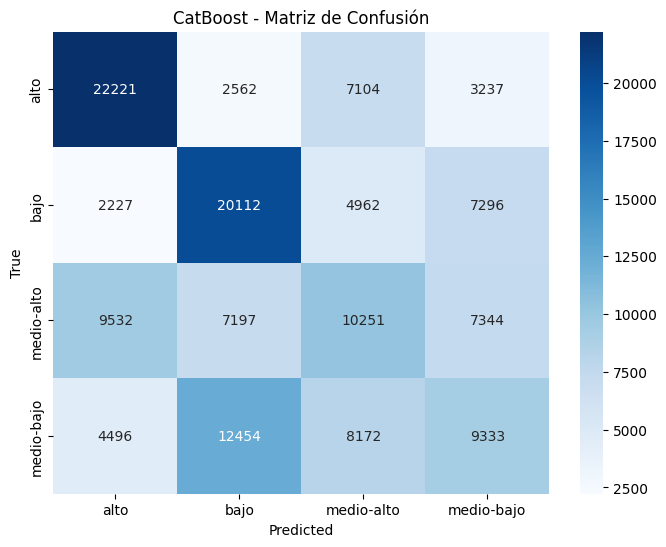

In [ ]:
y_pred = model.predict(X_val)

print(f"RESULTADOS DE EVALUACIÓN:")
print(f"Accuracy en validación: {accuracy_score(y_val, y_pred):.4f}")

print(classification_report(y_val, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.title("CatBoost - Matriz de Confusión")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Test y submisión

In [ ]:
X_test = test_df.drop(columns=['RENDIMIENTO_GLOBAL'], errors='ignore')

print(f"Test shape original: {X_test.shape}")

# Aplicar el mismo preprocesamiento que al train
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna("Unknown")
        
for col in numeric_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna(X[col].median())

# Asegurar que test tenga las mismas columnas que train
X_test = X_test.reindex(columns=X.columns, fill_value=0)

print(f"Test shape procesado: {X_test.shape}")
print(" Datos de test preparados")

print("\n Generando predicciones sobre test")
test_pred = model.predict(X_test)

print(f"Tipo de test_pred: {type(test_pred)}")
print(f"Shape de test_pred: {test_pred.shape if hasattr(test_pred, 'shape') else 'No tiene shape'}")
print(f"Primeras 5 predicciones: {test_pred[:5]}")

# Asegurar que test_pred sea un array 1D
if hasattr(test_pred, 'reshape'):
    test_pred = test_pred.flatten()
else:
    test_pred = np.array(test_pred).flatten()

# Detección de columna ID
test_id_col = None
for possible_id in ["ID", "id", "index", "row_id"]:
    if possible_id in test_df.columns:
        test_id_col = possible_id
        break

if test_id_col is None:
    print(" No se encontró columna ID, generando índices como ID")
    test_ids = np.arange(len(test_pred))  # Usar numpy array directamente
    test_id_col = "ID"
else:
    test_ids = test_df[test_id_col].values.flatten()  # Asegurar 1D
    print(f" Usando columna '{test_id_col}' como ID")

# Debugging detallado
print(f"\nDEBUGGING:")
print(f"test_ids tipo: {type(test_ids)}")
print(f"test_ids shape: {test_ids.shape if hasattr(test_ids, 'shape') else len(test_ids)}")
print(f"test_pred tipo: {type(test_pred)}")
print(f"test_pred shape: {test_pred.shape if hasattr(test_pred, 'shape') else len(test_pred)}")
print(f"test_ids ndim: {test_ids.ndim if hasattr(test_ids, 'ndim') else 'N/A'}")
print(f"test_pred ndim: {test_pred.ndim if hasattr(test_pred, 'ndim') else 'N/A'}")

# Verificar longitudes
if len(test_ids) != len(test_pred):
    print(f" Error: Longitudes no coinciden - IDs: {len(test_ids)}, Predicciones: {len(test_pred)}")
else:
    print(f" Longitudes coinciden: {len(test_ids)}")

# Crear submission con conversión explícita
try:
    submission = pd.DataFrame({
        test_id_col: list(test_ids),  # Convertir explícitamente a lista
        "RENDIMIENTO_GLOBAL": list(test_pred)  # Convertir explícitamente a lista
    })
    
    print(f"\n Distribución de predicciones:")
    print(pd.Series(test_pred).value_counts())

    submission.to_csv("submission_catboost.csv", index=False)
    print(f"\n 'submission_catboost.csv' generado correctamente con {submission.shape[0]} filas")
    print(f" Archivo guardado en: {os.path.abspath('submission_catboost.csv')}")
    
except Exception as e:
    print(f" Error al crear DataFrame: {e}")
    print(f"Intentando crear archivo manualmente...")
    
    # Crear archivo CSV manualmente como fallback
    with open("submission_catboost.csv", "w") as f:
        f.write(f"{test_id_col},RENDIMIENTO_GLOBAL\n")
        for i in range(len(test_pred)):
            f.write(f"{test_ids[i]},{test_pred[i]}\n")
    print("Archivo CSV creado manualmente")